# Goal
* Choose a genre as a test case for model development
* Build a Classification model to predict whether a film is or is not the test case genre
* Evaluate the model to determine if accuracy warrants continuing this process with other genres

In [1]:
# Imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

import wrangle as w
import explore as e
import model as m

# Wrangle

* Data acquired from [Kaggle](https://www.kaggle.com/datasets/victorsoeiro/netflix-tv-shows-and-movies?select=titles.csv)

* Each row in the data represents a show appearing on Netflix at the time data was collected
* Columns were restricted to description and genre
* The following modifications were made when cleaning the text in description
     * Converted to lowercase
     * Special characters removed
     * Remove non-ascii characters
     * Lemmatize tokens
     * Remove stop words using standard list plus two letter words and 'ing'
* Boolean columns for each genre appearing in the genres column were added 
     * These columns indicate if the show belonged to that genre
* Dataset contains 5791 rows after being prepared 
* Full dataset was split into train, validate and test sets 
     * Train set contains 3242 rows
     * Validate set contains 1390 rows
     * Test set contains 1159 rows

In [2]:
#acquire and prepare data
df = w.get_show_data()

# split data into train, validate and prep
train, validate, test = w.split_my_data(df)

# print number ow rows in train
print(f"Train set contains {train.shape[0]} rows of data")
print(f"Validate set contains {validate.shape[0]} rows of data")
print(f"Test set contains {test.shape[0]} rows of data")

Train set contains 3242 rows of data
Validate set contains 1390 rows of data
Test set contains 1159 rows of data


# Explore

## 1. Choose a genre as a test case using the following criteria:
   * Genre has large representation in the data
   * Genre has a large number of unique words
   * Genre has a high number of unique words appearing in each description
   * Genre is relatively easy for a human to intuit 

## 2. Explore the chosen genre:
   * How much of the data belongs to the test genre?
   * What does the relative occurrence of words in the test genre or non-test genre films tell us?

In [3]:
# get set of genres
gen_set = e.get_gens(train)

# get relative word frequency list and list of only the numbers
word_freq = e.get_word_freq(train)
word_counts = e.get_counts(word_freq)

# get relative document frequency list and list of only the numbers
doc_freq = e.get_doc_freq(train)
doc_counts = e.get_counts(doc_freq)

## 1. Choose a Test Case 

### What is the distribution of genres in the train data?

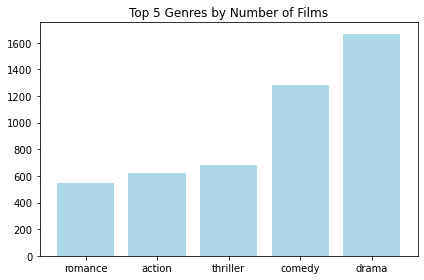

In [4]:
# display distribution of genres
shows_per_gen = e.get_shows_per_gen(train, gen_set)
e.get_bar(shows_per_gen, "Top 5 Genres by Number of Films")

* Comedy and Drama are by far the most highly represented genres in the training data.

### How many different unique words appear in each genre? 

* Unique Words are words that appear in the descriptions of films in a given genre and do not appear in descriptions of films that are not in that genre

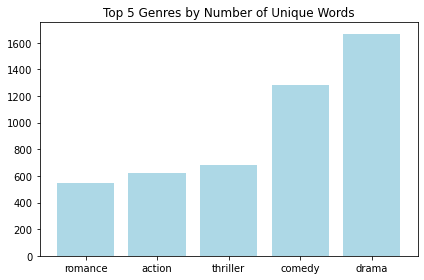

In [5]:
# display number of different unique words in each genre
unique_words_per_gen = e.get_unique_words_per_gen(train, gen_set)
e.get_bar(shows_per_gen, "Top 5 Genres by Number of Unique Words")

* Comedy and Drama contain by far the largest number of different unique words

### What is the average number of times unique words appear in descriptions of each genre?

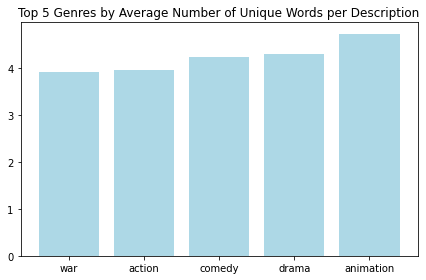

In [6]:
# get frequency of unique words pre genre
unique_word_appearance_per_genre = e.get_unique_word_appearance_per_genre(train, gen_set)
e.get_bar(unique_word_appearance_per_genre, "Top 5 Genres by Average Number of Unique Words per Description")

* Not a great deal of variance in unique word appearance frequency
* Animation has the highest appearance frequency
* Comedy and Drama are close behind

## Test Case Conclusion

* Comedy and Drama have high values in all of the testable criteria
   * Representation in the data
   * Number of unique words
   * High number of unique words appearing in each description
* Either genre would make a reasonable choice
* The last criteria is how easily the genre would be to intuit for a human
    * Comedy seems to me the earlier of the two genres for a human to intuit 

**For these reasons I am choosing comedy as the test case for this project**

## 2) Explore the Comedy Genre

* What percent of the data is classified as a Comedy?
* What does the relative occurrence of words in comedy or non-comedy films tell us?

## How much of the data is Comedy?

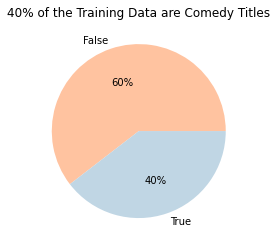

In [7]:
e.omni_pie(train.comedy, "40% of the Training Data are Comedy Titles")

## What does the relative occurrence of words in comedy or non-comedy films tell us?

I will look at two different measures:
* **Relative Word Frequency** - the number of times a given word appears in comedy film descriptions minus the number of times that word appears in non-comedy film descriptions
* **Relative Document Frequency** - the number of comedy descriptions a given word appears in minus the number of non-comedy films the word appears in

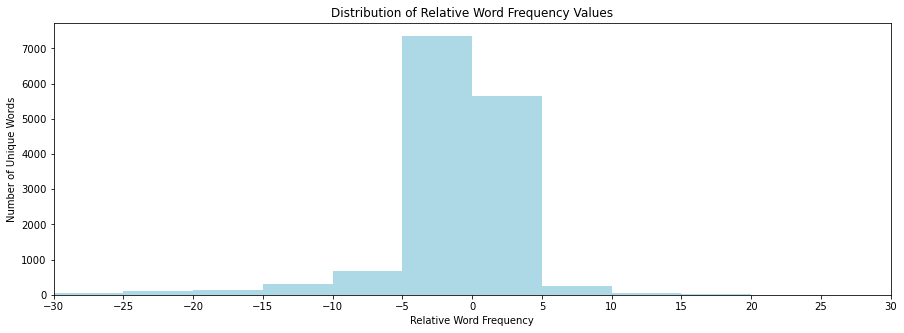

In [8]:
e.get_hist(word_counts,"Distribution of Relative Word Frequency Values","Relative Word Frequency")

* The Majority of the data is between -5 and 5
    * Removing these "low value" numbers may reduce noise in the model
    * Because the data is so focused around the 5 to - 5 mark I will concentrate on that range to remove potential noise 
* There is a negative skew to the data likely due to the 60/40 imbalance in the data
    * Negative values may be caused or inflated by the skew 
    * Positive values are more likely to be true indicators of comedy films because the works against them     

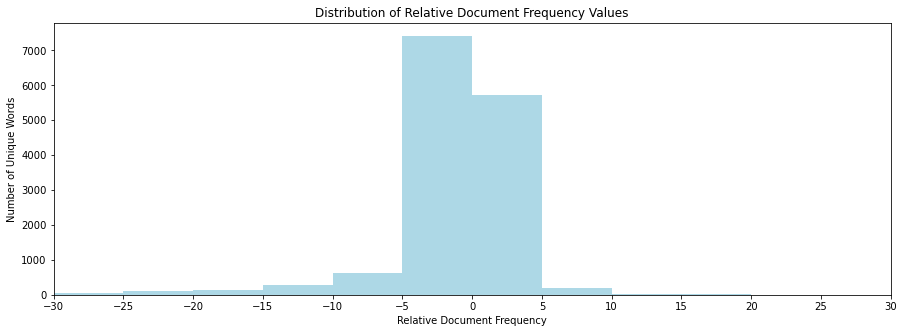

In [9]:
e.get_hist(doc_counts, "Distribution of Relative Document Frequency Values","Relative Document Frequency")

* The Majority of the data is between -5 and 5
    * Removing these "low value" numbers may reduce noise in the model
    * Because the data is so focused around the 5 to - 5 mark I will concentrate on that range to remove potential noise 
* There is a negative skew to the data likely due to the 60/40 imbalance in the data
    * Negative values may be caused or inflated by the skew 
    * Positive values are more likely to be true indicators of comedy films because the works against them     
* Distribution of relative word frequencies and relative document frequencies are very similar

## What do the most extreme 15 most extreme positive and negative frequency values tell us?

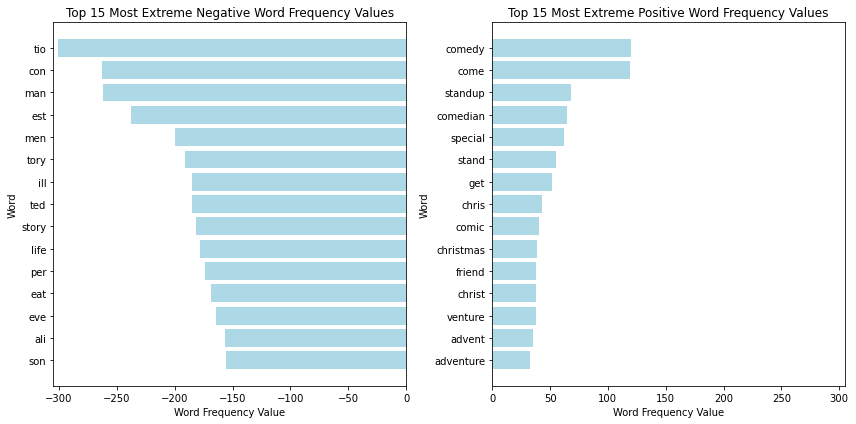

In [10]:
e.display_ext_values(dict(word_freq[:15]),"Top 15 Most Extreme Negative Word Frequency Values", dict(word_freq[-15:]), "Top 15 Most Extreme Positive Word Frequency Values","Word Frequency Value", "Word", 305)

* Extreme positive values are much closer to zero than their negative counterparts
    * Evidance that the negative skew is impacting the data 
* Extreme positive values contain words that are intuitively associated with comedy
    * Examples include comedy, standup, and special
* Extreme negative values contain words that are not intuitively disassociated with comedy 
    * Examples include per, life, and man
    * This supports the idea some negative values could be resulting from the skew in the data

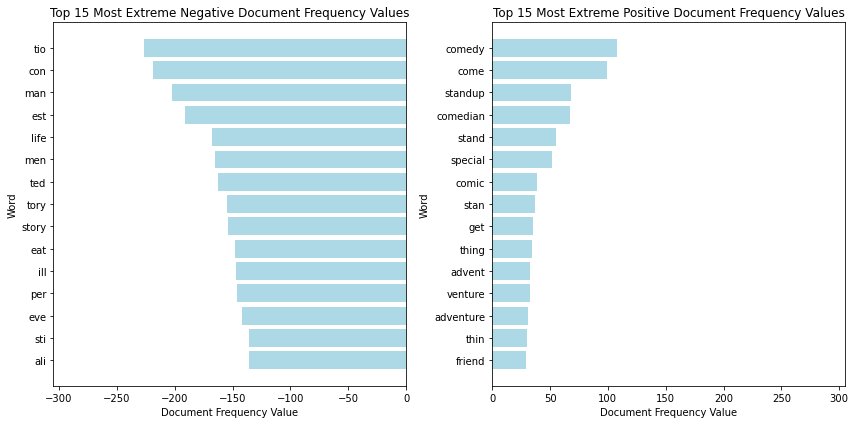

In [11]:
e.display_ext_values(dict(doc_freq[:15]), "Top 15 Most Extreme Negative Document Frequency Values", dict(doc_freq[-15:]), "Top 15 Most Extreme Positive Document Frequency Values", "Document Frequency Value", "Word", 305)

* The same overall trends are present in document frequency values that are in word frequency values
* Extreme positive values are much closer to zero than their negative counterparts
    * Evidance that the negative skew is impacting the data 
* Extreme positive values contain words that are intuitively associated with comedy
    * Examples include comedy, standup, and special
* Extreme negative values contain words that are not intuitively disassociated with comedy 
    * Examples include per, life, and man
    * This supports the idea some negative values could be resulting from the skew in the data

## Exploration Summary

* Training data has 60% comedy and 40% non-comedy data
* Both Relative Frequency metrics have shown a negative skew in their distributions
* High positive value words are likely to be good indicators of comedy because the skew in the distribution works against positive values and many of the highest positive value words are intuitively indicative of the comedy genre
* High negative value words may not be true indicators of comedy because the skew in the distribution may result in artificially low or negative values and many of the highest negative value words are not intuitively indicative of not being in the comedy genre
* In future iterations of this project I will look for ways to gauge relative frequency that will not be as sensitive to imbalances in the data

# Predictions Using Unique Words

* 4 or more unique words appear in the description of each comedy film on average
* I will now attempt to predict if a film is in the comedy genre using uniquethe following method:
    * Unique words for comedy and non-comedy will be identified using train data and used to predict validate data
    * Values will be assigned to each prediction according the presence/number of unique comedy and non-comedy words
    * Prediction methods will be evaluated in terms of overall accuracy and override accuracy
        * Overall Accuracy = total correct predictions / total attempted predictions
            * Non-Boolean results will count as missed predictions
        * Override Accuracy = total correct True or False predictions / Total True or False predictions
            * Non-Boolean results will not be considered
    * I will use two methods of prediction:
        * Presence of unique words
            * Has unique words for comedy and no unique words for non-comedy = True
            * Has unique words for non-comedy and no unique words for comedy = False
            * Has both = Has Both 
            * Has neither = Contains Neither
        * Majority of unique words
            * Has more comedy unique words than non-comedy unique words = True
            * Has more non-comedy unique words than comedy unique words = False
            * Has an equal number of comedy and non-comedy unique words = Equal Count
            * Has neither = Has Neither
    * Due to the 60/40 split in the data I am setting the baseline accuracy of 60% 
* If the overall accuracy of this prediction method is high enough it could be used as an alternative to traditional modeling. 
* If the override accuracy beats a given model's overall accuracy it could be used in conjunction with traditional modeling to override model results where the prediction method produces a boolean result.

In [12]:
# get set of words occuring in comedy and non-comedy descriptions
com_train = e.get_description_set_of_words(train[train.comedy == True])
non_train = e.get_description_set_of_words(train[train.comedy == False])

# get set of words appearing in only comedy or non-comedy descriptions
com_unique_train = com_train.difference(non_train)
non_unique_train = non_train.difference(com_train)

# get train and validate dataframes with only description and comedy columns
train_evaluation_df = train[['description','comedy']]
validate_evaluation_df = validate[['description','comedy']]

# Sanity Test - Predicting Train Using Presence of Unique Words 

In [13]:
m.get_predictions_presence(train_evaluation_df, com_unique_train, non_unique_train)

Prediction Value Counts
-----------------------
False               1837
True                1168
contains neither     237
Name: prediction, dtype: int64

Evaluation Results
-----------------------
True     3005
False     237
Name: evaluation, dtype: int64

Overall Accuracy
-----------------------
93.0

Override Accuracy
-----------------------
100.0


* Sanity Test performed as expected 
    * Method produced the same number of incorrect predictions and "contains neither" results giving evidence that
        * Train data cases that contain unique words for either comedy or non-comedy correctly identified 
        * Those that did not were classified as "contains neither" 

# Predicting Validate Using Presence of Unique Words 

In [14]:
m.get_predictions_presence(validate_evaluation_df, com_unique_train, non_unique_train)

Prediction Value Counts
-----------------------
contains both       512
False               486
contains neither    213
True                179
Name: prediction, dtype: int64

Evaluation Results
-----------------------
False    941
True     449
Name: evaluation, dtype: int64

Overall Accuracy
-----------------------
32.0

Override Accuracy
-----------------------
68.0


* Overall Accuracy is poor
    * A large number of films contained unique words from both comedy and non-comedy or contained no unique words
        * These words could not generate at True/False prediction and greatly hampered the method's accuracy
* Override accuracy is 68%
    * I would not recommend moving forward with a model that predicts less than 70%
        * This method would not make a good override because its accuracy would not be higher than any model I would move forward with

# Predicting Validate Using Number of Unique Words 

In [15]:
m.get_predictions_number(validate_evaluation_df, com_unique_train, non_unique_train)

Prediction Value Counts
-----------------------
False          739
equal count    379
True           272
Name: prediction, dtype: int64

Evaluation Results
-----------------------
False    708
True     682
Name: evaluation, dtype: int64

Overall Accuracy
-----------------------
49.0

Override Accuracy
-----------------------
67.0


* Overall Accuracy improves, but is still below baseline
    * Increase is likely due to increasing the number of True/False predictions it could make
* Override Accuracy is slightly worse using this method at 7% above baseline

## Predicting Using Unique Words Conclusion

* Baseline 60% 
* Predicting on Presence of Unique Words 
    * Overall Accuracy of 32% is far below baseline
    * Override Accuracy of 68% is not sufficient to use as an override
* Predicting on Number of Unique Words
    * Overall Accuracy of 49% is far below baseline
    * Override Accuracy of 67% is worse than predicting on presence alone
* At the moment I do not recommend using either method to make predictions
    * Overall accuracy is below baseline on both
    * Using this method as an override is only useful if the model being overridden is predicting less accurately
        * a model that predicts less accurately than 7-8% above a 60% baseline would not be suitable for the next step of the project
* Adjustments to these methods may yield better results
    * In future iterations of this project I will try totaling the relative frequency of each word in the description and predicting comedy if total is positive and non-comedy if the total is negative

# Modeling

* Models will be evaluated in terms of overall accuracy 
* Because of the 60/40 split in the data baseline will be set at 60%
* Models will first be evaluated on train and validate data
* The top performing model will be evaluated on Test to gauge how it will perform on unseen data
* I will also be gauging the effect of different data preparation and feature engineering techniques on model accuracy 
    * Vectorization strategies
        * Count - Each word is assigned a number value for each film counting the number of times it appears in the description
       * TF-IDF - Each word is assigned a number value for each film in a calculation which lowers the value based on the number of descriptions it appears in and raises the value based on the number of times the word appears in the description of the film
    * Dropping features of words with low relative frequency 
        * I will examine two different measures
            * **Relative Word Frequency** - the number of times a given word appears in comedy film descriptions minus the number of times that word appears in non-comedy film descriptions
            * **Relative Document Frequency** - the number of comedy descriptions a given word appears in minus the number of non-comedy films the word appears in
        * I will drop features at different threshold levels
            * I will test dropping at threshold values of 0, 1, 2, 3, 4, and 5
            * Words with a relative frequency between threshold value and negative threshold will be removed 
    * I will use the following machine learning models in my analysis
        * Decision Tree
        * Random Forest
        * K Nearest Neighbors
        * Logistic Regression

### Note!

* Model evaluations take a long time to run! If you are running a cloned version of this notebook please be patient!

In [16]:
# seperate train, validate and test data into X (description) and y (comedy)
train_X = train[['description']].reset_index(drop=True)
train_y = train[['comedy']].reset_index(drop=True)

validate_X = validate[['description']].reset_index(drop=True)
validate_y = validate[['comedy']].reset_index(drop=True)

test_X = test[['description']].reset_index(drop=True)
test_y = test[['comedy']].reset_index(drop=True)

# vectorize X data using counts
train_counts, validate_counts, test_counts = m.get_vectorized_data(train_X, validate_X, test_X, CountVectorizer())

# vectorize X data using TF-IDF
train_tfidf, validate_tfidf, test_tfidf = m.get_vectorized_data(train_X, validate_X, test_X, TfidfVectorizer())

## Count Vectorized Data - Dropping Low Relative Word Frequency Columns

In [17]:
# runs model evaluations and generates results tabled by threshold and algorithem used
m.get_acc_tables(train_counts, train_y, validate_counts, validate_y, dict(word_freq))


 _____________________________________________________________________________ 
| Threshold |        Model         | Accuracy On Train | Accuracy on Validate |
 ----------------------------------------------------------------------------- 
|    N/A    |    Decision Tree     |      99.97%       |        63.88%        |
|     0     |    Decision Tree     |      99.97%       |        66.69%        |
|     1     |    Decision Tree     |      99.97%       |        64.89%        |
|     2     |    Decision Tree     |      99.97%       |        64.1%         |
|     3     |    Decision Tree     |      99.97%       |        62.95%        |
|     4     |    Decision Tree     |      99.97%       |        62.37%        |
|     5     |    Decision Tree     |      99.94%       |        64.82%        |
 ----------------------------------------------------------------------------- 

 _____________________________________________________________________________ 
| Threshold |        Model         | A

* Top performing model is logistic regression with removal threshold of 1
    * The model's accuracy of 72.01% is ~12% higher than baseline
* Other models showed some improvement when removing low relative word frequency columns 
    * Threshold for increasing accuracy appears to be from 0-3, higher values result in lower accuracy

## Count Vectorized Data - Drop Low Relative Document Frequency Columns

In [18]:
# runs model evaluations and generates results tabled by threshold and algorithem used
m.get_acc_tables(train_counts, train_y, validate_counts, validate_y, dict(doc_freq))


 _____________________________________________________________________________ 
| Threshold |        Model         | Accuracy On Train | Accuracy on Validate |
 ----------------------------------------------------------------------------- 
|    N/A    |    Decision Tree     |      99.97%       |        63.88%        |
|     0     |    Decision Tree     |      99.97%       |        66.33%        |
|     1     |    Decision Tree     |      99.97%       |        65.47%        |
|     2     |    Decision Tree     |      99.97%       |        65.11%        |
|     3     |    Decision Tree     |      99.97%       |        64.68%        |
|     4     |    Decision Tree     |      99.97%       |        61.22%        |
|     5     |    Decision Tree     |      99.94%       |        61.44%        |
 ----------------------------------------------------------------------------- 

 _____________________________________________________________________________ 
| Threshold |        Model         | A

* Top performing model is logistic regression with removal threshold of 1
    * The model's accuracy of 71.65% is ~12% higher than baseline
    * However this model does not perform as well as the previous top model
* Decision Tree and Random forest models showed some improvement when removing low relative document frequency columns 
    * Threshold for increasing accuracy was 0, higher values resulted in lower accuracy
* K Neighbors was not improved by removing low relative document frequency columns 

## TF-IDF Vectorized Data - Drop Low Relative Word Frequency Columns

In [19]:
m.get_acc_tables(train_tfidf, train_y, validate_tfidf, validate_y, dict(word_freq))


 _____________________________________________________________________________ 
| Threshold |        Model         | Accuracy On Train | Accuracy on Validate |
 ----------------------------------------------------------------------------- 
|    N/A    |    Decision Tree     |      99.97%       |        61.15%        |
|     0     |    Decision Tree     |      99.97%       |        62.45%        |
|     1     |    Decision Tree     |      99.97%       |        61.44%        |
|     2     |    Decision Tree     |      99.97%       |        59.78%        |
|     3     |    Decision Tree     |      99.97%       |        60.36%        |
|     4     |    Decision Tree     |      99.97%       |        58.78%        |
|     5     |    Decision Tree     |      99.97%       |        60.79%        |
 ----------------------------------------------------------------------------- 

 _____________________________________________________________________________ 
| Threshold |        Model         | A

* Top performing model is logistic regression with removal threshold of 0
    * The model's accuracy of 71.01% is ~11% higher than baseline
    * However this model does not perform as well as the previous top model
* Decision Tree showed some improvement when removing low relative word frequency columns 
    * Threshold for increasing accuracy was 0, higher values resulted in lower accuracy
* K Neighbors was not improved by removing low relative document frequency columns 

## TF-IDF Vectorized Data - Drop Low Relative Document Frequency Columns

In [20]:
m.get_acc_tables(train_tfidf, train_y, validate_tfidf, validate_y, dict(doc_freq))


 _____________________________________________________________________________ 
| Threshold |        Model         | Accuracy On Train | Accuracy on Validate |
 ----------------------------------------------------------------------------- 
|    N/A    |    Decision Tree     |      99.97%       |        61.15%        |
|     0     |    Decision Tree     |      99.97%       |        60.72%        |
|     1     |    Decision Tree     |      99.97%       |        59.93%        |
|     2     |    Decision Tree     |      99.97%       |        60.94%        |
|     3     |    Decision Tree     |      99.97%       |        61.58%        |
|     4     |    Decision Tree     |      99.97%       |        59.28%        |
|     5     |    Decision Tree     |      99.94%       |        59.64%        |
 ----------------------------------------------------------------------------- 

 _____________________________________________________________________________ 
| Threshold |        Model         | A

* Top performing model is Random Forest with removal threshold of 0
    * The model's accuracy of 71.86% is ~11% higher than baseline
    * However this model does not perform as well as the previous top model
    * Threshold for increasing was 0, higher values resulted in lower accuracy
* Decision Tree showed some improvement at threshold 3, but lost accuracy at all other threshold levels
* Models other than  were not improved by removing low relative document frequency columns 

# Top Model  

* Uses count vectorized data
* Removes words using relative word frequency
* Uses a threshold of 0
* Is a Logistic Regression model
* Has an accuracy of 72.01% 
* Beats Baseline by ~12% on validate data

# Top Model Evaluated on Test

In [21]:
m.evaluate_model_test(train_counts, train_y, test_counts, test_y, dict(word_freq), 1)

The top model predicts with 72.99% accuracy on test data


# Model Conclusions

* Top model was able to predict with 72.99% on test data beating baseline by ~13%
* Logistic Regression produced the most accurate models
* Vectorizing using counts seems to outperform vectorizing using TF-IDF on this data
    * Difference in accuracy was small
* Removing low relative frequency words seems to outperform removing words with low document frequency
    * Difference in accuracy was small
    * Models only seemed to benefit from removal at a threshold of 0-3, higher thresholds yield less accuracy
    * Majority of models only benefit from removal at 0-1
    * K Neighbors benefited the least from removing low relative frequency features
* Models seem to overfit across the board

# Process Summary

* Comedy was chosen as the test case to build a predictive model using the following criteria 
    * Representation in the data
    * Number of unique words
    * High number of unique words appearing in each description
    * human intuitability
* The comedy genre was explored 
    * Data Split
        * Training data has 60% comedy and 40% non-comedy data 
            * This likely caused the relative frequency numbers to skew toward the negative
    * Relative Frequency Distribution
        * Overall trends in the data were the same using relative word frequency and relative document frequency
            * Majority of the data is between -5 and 5
                * Concluded using removal thresholds that are between 0-5 to remove noise would likely produce the most accurate models
            * There is a negative skew to the data likely due to the 60/40 imbalance in the data
    * Extreme Value Words
        * Extreme positive values are much closer to zero than their negative counterparts 
            * More evidence the data is skewed
        * Extreme positive values represent words that are intuitively indicative of comedy films
        * Extreme negative words represent words that are not intuitively indicative of non-comedy films 
            * This gives evidence that the skew is likely having an impact on the relative frequency data
        * High positive value words are still likely to be strong indicators of comedy because the skew works against high positive value words
* Methods were developed to predict comedy genre
    * Pre-Modeling Predictions
        * Predicting comedy using presence or number of unique words yielded disappointing results
            * Presence of Unique Words
                * Overall Accuracy 32%
                * Override Accuracy 68%
            * Number of Unique Words
                * Overall Accuracy 49%
                * Override Accuracy 67%
            * Overall accuracy for both attempts were less than baseline
            * Override accuracy for both attempts were above baseline but worse then the final model 
            * Methods are not viable for predicting comedy at this time
* Machine learning models were developed to predict comedy genre
    * Top Performing Model 
        * Uses count vectorized data
        * Removes words using relative word frequency
        * Uses a threshold of 0
        * Is a Logistic Regression model
        * Has an accuracy of 72.99% on test data beating baseline by ~13%
    * Count Vectorized data seems to outperform TF-IDF data by a small margin
    * Removing word features due to low word frequency seems to outperform removing word features do to low document frequency by a small margin

# Next Steps and Recommendations

* At this time the accuracy of the best performing model stands at 72.99% beating baseline by ~13%
* Enough promise has been shown for me to recommend moving forward with constructing a pipeline to create and evaluate models for predicting each genre individually 
* I also recommend putting more time into developing a more accurate model using the following guidelines 
    * Focus on Logistic Regression models
        * This model was consistently the highest performer on its default settings
        * It may be possible to increase its accuracy by adjusting its hyperparameters
    * Focus on count vectorized Data
        * This type of vectorization seems to result in slightly higher accuracy than TF-IDF
    * Focus on relative frequency by word count
        * Removing low relative frequency words seems to outperform removing words with low document frequency 
        * Normalize relative frequency values to avoid skewing the data  
    * Rethink non-modeling approach to predictions
        * Try making predictions by adding the relative frequency numbers of all of the words in the description
            * positive results would be predicted as comedy 
            * negative results would be predicted as non-comedy